# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda, BatchNormalization, ReLU

# Loading data

In [2]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()
X = faces.images
X = np.expand_dims(X, axis=-1) 

y = faces.target
# Print the shape of the data
print(f'Shape of X (features): {X.shape}')  
print(f'Shape of y (labels): {y.shape}')    

# Number of occurances of each label 
unique_digits, counts = np.unique(y, return_counts=True)
face_counter = {}
for i in range(len(unique_digits)):
    face_counter[unique_digits[i]] = counts[i]

# Get image shape
IMG_SHAPE = X[0].shape
print(f"IMG_SHAPE = ", IMG_SHAPE)



Shape of X (features): (400, 64, 64, 1)
Shape of y (labels): (400,)
IMG_SHAPE =  (64, 64, 1)


# Creating pairs

In [3]:
def create_balanced_pairs(X, y, unique_labels, num_pairs=1000):
    """Creates an equal number of positive (same class) and negative (different class) pairs."""
    pairs = []
    labels = []
    
    half_pairs = num_pairs // 2  # Half positive, half negative
    
    # Step 1: Create positive pairs
    for _ in range(half_pairs):
        # Randomly select a class
        digit_class = np.random.choice(unique_labels)
        
        # Get indices for this class
        indices = np.where(y == digit_class)[0]
        
        # Select 2 random indices from the same class
        if len(indices) >= 2:
            idx1, idx2 = np.random.choice(indices, size=2, replace=False)
            image1 = X[idx1]
            image2 = X[idx2]
            
            # Add the pair and label it as 1 (positive pair)
            pairs.append([image1, image2])
            labels.append(1.)
    
    # Step 2: Create negative pairs
    for _ in range(half_pairs):
        # Randomly select two different classes
        class1, class2 = np.random.choice(unique_labels, size=2, replace=False)
        
        # Get indices for each class
        indices1 = np.where(y == class1)[0]
        indices2 = np.where(y == class2)[0]
        
        # Select one image from each class
        idx1 = np.random.choice(indices1)
        idx2 = np.random.choice(indices2)
        
        image1 = X[idx1]
        image2 = X[idx2]
        
        # Add the pair and label it as 0 (negative pair)
        pairs.append([image1, image2])
        labels.append(0.)
    
    # Convert pairs and labels to numpy arrays
    return np.array(pairs), np.array(labels)

In [4]:
pairs_train, labels_train = create_balanced_pairs(X, y, [0, 1, 2, 3, 4, 5, 6], 10000)
pairs_test, labels_test = create_balanced_pairs(X, y, [7, 8, 9], 1000)
pairs_train.shape

(10000, 2, 64, 64, 1)

# Visualize data

In [5]:
X1_train = np.array([pair[0] for pair in pairs_train])  # First image in each pair
X2_train = np.array([pair[1] for pair in pairs_train])  # Second image in each pair

X1_test = np.array([pair[0] for pair in pairs_test])  # First image in each pair
X2_test = np.array([pair[1] for pair in pairs_test])  # Second image in each pair

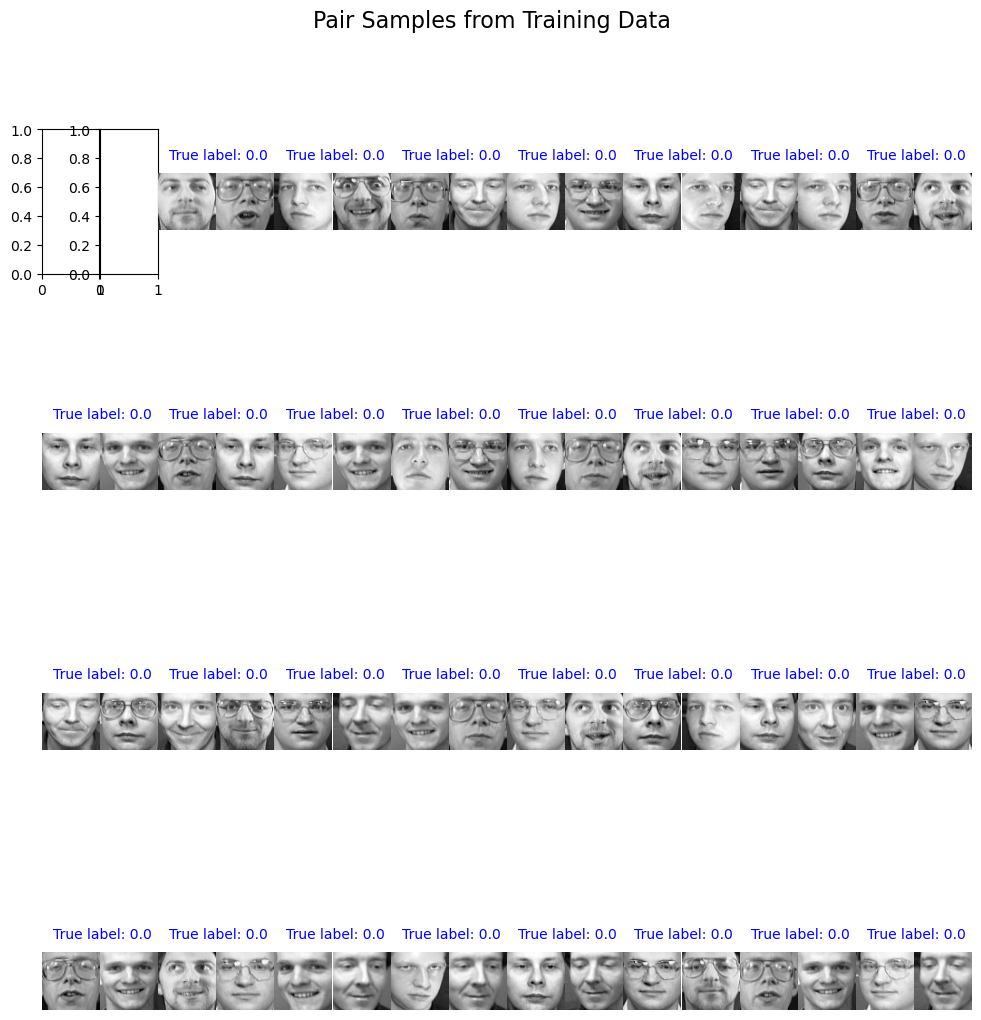

In [6]:
# Define the number of pairs to visualize and the layout
num_pairs = 32
pairs_per_row = 8
rows = num_pairs // pairs_per_row

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

# Plot each pair with its label
for i in range(1, num_pairs):
    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2  # Each pair occupies two columns

    # Display the first image of the pair (X1_train[i])
    axes[row, col].imshow(X1_train[-i], cmap='gray')  # Adjust cmap as needed
    axes[row, col].axis('off')

    # Display the second image of the pair (X2_train[i])
    axes[row, col + 1].imshow(X2_train[-i], cmap='gray')  # Adjust cmap as needed
    axes[row, col + 1].axis('off')

    # Add the label above the pair, centered
    label = f"True label: {labels_train[-i]}"
    axes[row, col].set_title(label, fontsize=10, color="blue", pad=10, loc='center', x=1.05)
    axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

plt.suptitle("Pair Samples from Training Data", fontsize=16)
plt.show()

# Build CNN Part

In [7]:
cnn_part = Sequential()
cnn_part.add(Conv2D(filters=64, kernel_size=(10,10), input_shape=IMG_SHAPE))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(128, (7, 7), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(256, (4, 4), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Flatten())
cnn_part.add(BatchNormalization())  # Batch normalization before the dense layer's activation
cnn_part.add(Dense(128, activation="sigmoid"))


In [8]:
cnn_part.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 64)        6464      
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 55, 55, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       401536    
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 128)      5

# Build SNN

In [9]:
input1, input2 = Input(shape=IMG_SHAPE, name="Image1"), Input(shape=IMG_SHAPE, name="Image2")
# Share the single output layer for both inputs
embedding1, embedding2 = cnn_part(input1), cnn_part(input2)

In [10]:
from tensorflow.keras import backend as K

# Creating the final layer of the SNN
def euclidean_distance(vectors):
    # vectors is a list containing two tensors
    x, y = vectors
    # Compute the Euclidean distance between x and y
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, y_pred):
    """
    y_true: Binary labels (1 for similar pairs, 0 for dissimilar pairs)
    y_pred: Euclidean distances between the output embeddings
    """
    margin = 1.0  # This can be tuned
    positive_loss = y_true * K.square(y_pred)  # Loss for similar pairs
    negative_loss = (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))  # Loss for dissimilar pairs
    return K.mean(positive_loss + negative_loss)  # Mean loss for the batch

In [11]:
merged = Lambda(lambda tensors: abs(tensors[0] - tensors[1]))([embedding1, embedding2])
final_output = Dense(1, activation='sigmoid')(merged)
#distance_layer = Lambda(euclidean_distance, output_shape=(1,))([embedding1, embedding2])
#final_output = Dense(1, activation='sigmoid')(distance_layer)

In [12]:
snn = Model((input1, input2), final_output)

In [13]:
from tensorflow.keras.optimizers import Adam

snn.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Loss function for classification
              metrics=['accuracy']
              )

In [14]:
snn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image1 (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 Image2 (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          1238592     ['Image1[0][0]',                 
                                                                  'Image2[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['sequential[0][0]',         

# Train SNN

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)
snn.fit(x=[X1_train, X2_train], 
        y = labels_train, 
        batch_size = 64, 
        epochs=100,
        validation_data=([X1_test, X2_test], labels_test),
        callbacks=[es],
        shuffle=True)

Epoch 1/100
157/157 [==============================] - 175s 1s/step - loss: 0.1306 - accuracy: 0.9838 - val_loss: 0.7376 - val_accuracy: 0.5000
Epoch 2/100
157/157 [==============================] - 189s 1s/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.4938 - val_accuracy: 0.6840
Epoch 3/100
157/157 [==============================] - 188s 1s/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.5658 - val_accuracy: 0.7140
Epoch 4/100
157/157 [==============================] - 190s 1s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.5865 - val_accuracy: 0.7550
Epoch 5/100
157/157 [==============================] - 190s 1s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.6718 - val_accuracy: 0.7000


# Test

In [16]:
y_predict = snn.predict([X1_test,X2_test])
from sklearn.metrics import accuracy_score
Y_predict_decisions = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        Y_predict_decisions.append(1)
    else:
        Y_predict_decisions.append(0)

# Calculate accuracy
accuracy = accuracy_score(labels_test, Y_predict_decisions)
print("Accuracy:", accuracy)

32/32 [==============================] - 5s 143ms/step
Accuracy: 0.7


# Visualize predictions

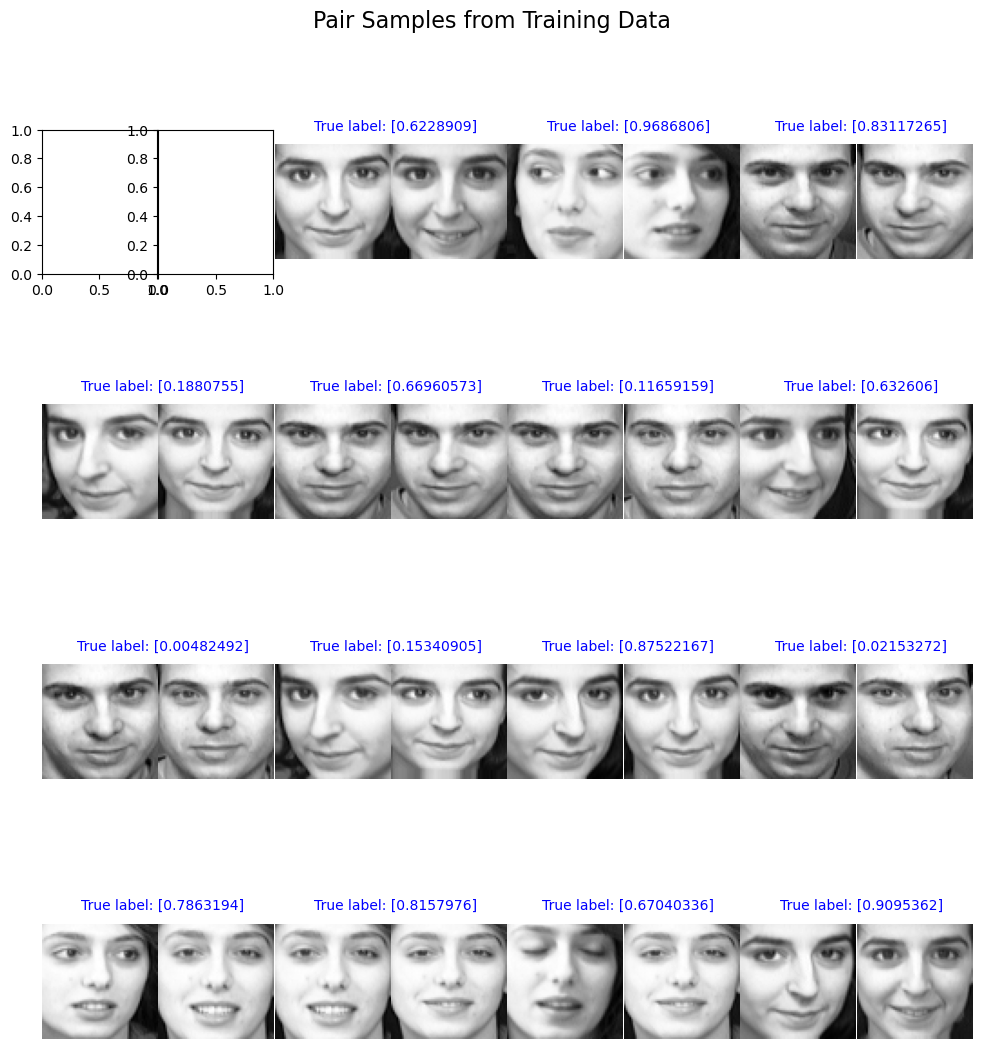

In [17]:
# Define the number of pairs to visualize and the layout
num_pairs = 16
pairs_per_row = 4
rows = num_pairs // pairs_per_row

# Create a figure with multiple subplots
fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

# Plot each pair with its label
for i in range(1, num_pairs):
    row = i // pairs_per_row
    col = (i % pairs_per_row) * 2  # Each pair occupies two columns

    # Display the first image of the pair (X1_train[i])
    axes[row, col].imshow(X1_test[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col].axis('off')

    # Display the second image of the pair (X2_train[i])
    axes[row, col + 1].imshow(X2_test[i], cmap='gray')  # Adjust cmap as needed
    axes[row, col + 1].axis('off')

    # Add the label above the pair, centered
    label = f"True label: {y_predict[i]}"
    axes[row, col].set_title(label, fontsize=10, color="blue", pad=10, loc='center', x=1.05)
    axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

plt.suptitle("Pair Samples from Training Data", fontsize=16)
plt.show()

# Next 
- Data Augmentation 
- LFW 
- Test with system 